In [1]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
#import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec, SpectralMixtureComponent
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses
from bnqdflow.effect_size_measures import MAE

discontinuity: 0
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function wi

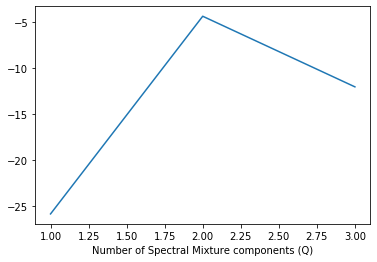

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

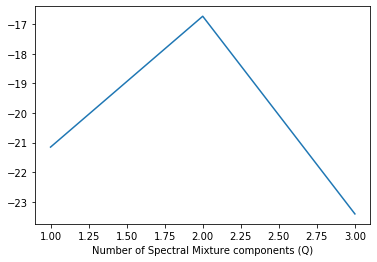

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

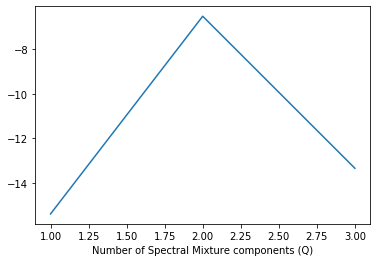

2 2 2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 

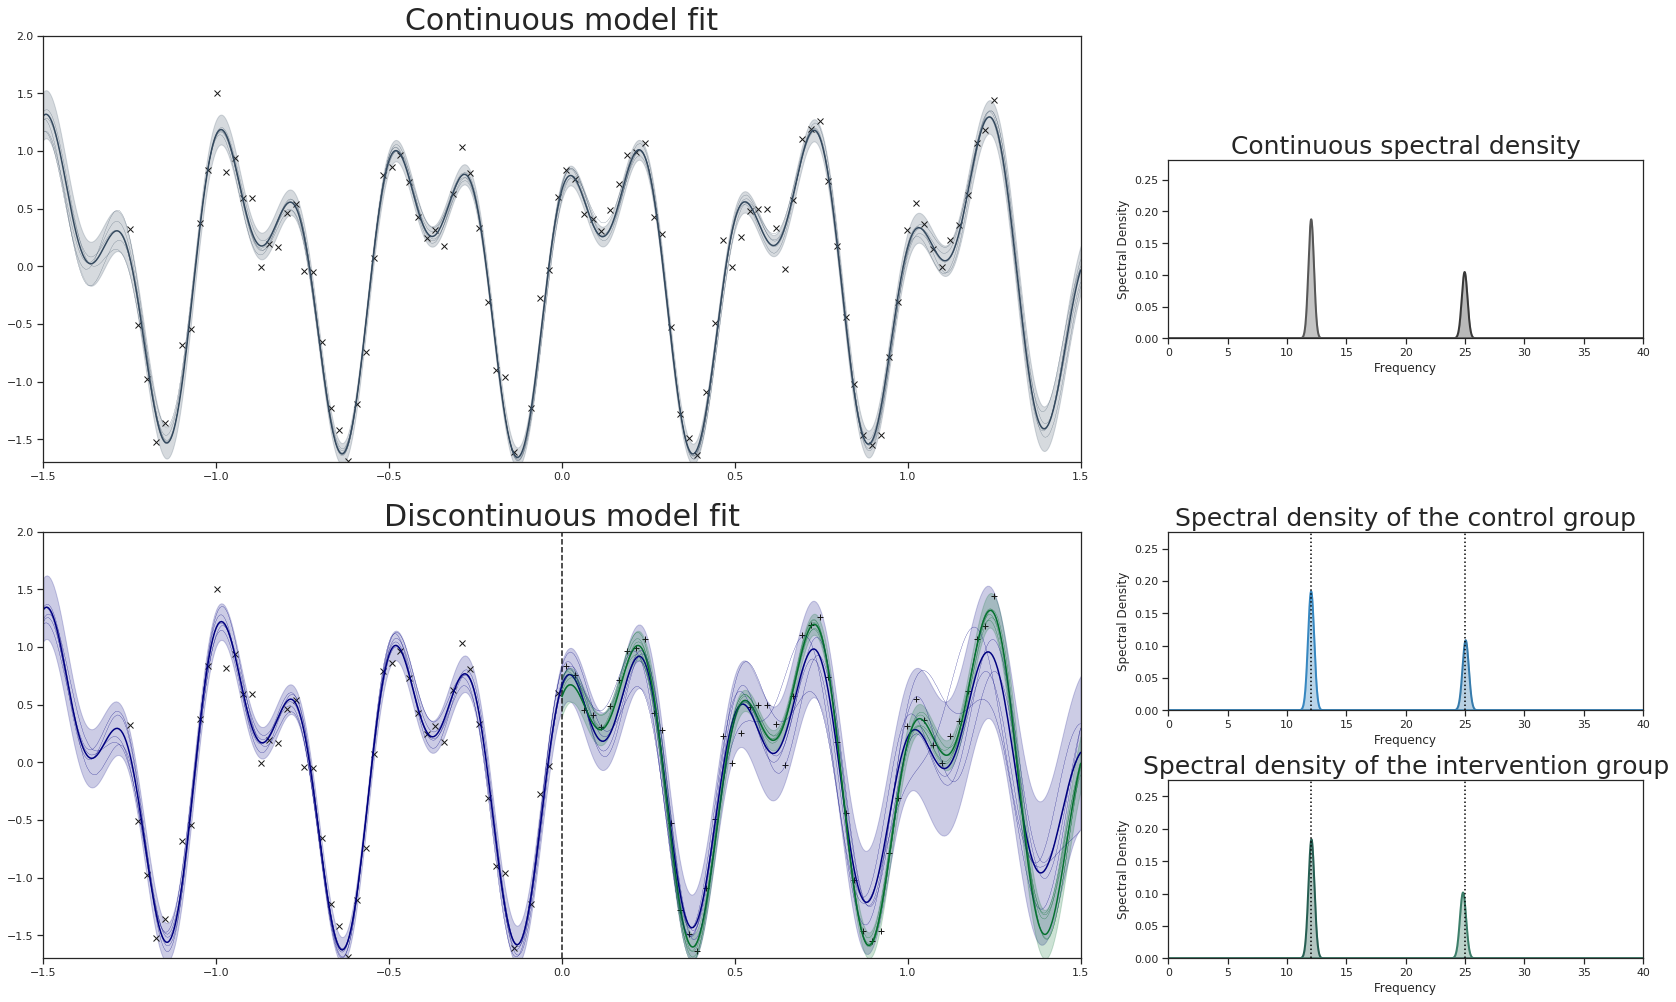

Bayes factors: [[-23.92940513]]


In [2]:
# Triple cosine Time series fit + spectra 
# ---------------------------

np.random.seed(1)

# Create synthetic data
N           = 100
sigma       = .2
b           = 0.
x           = np.linspace(-1.25, 1.25, N)
fs          = 200/2.4
x1, x2      = x[x<=b], x[x>b]

xlim        = [-1.5,1.5]
xx          = np.linspace(xlim[0], xlim[1], 1000).reshape(1000, 1)  # (N, D)
# max_freq    = 4 * 2 * np.pi
# max_length  = 10.


# Plotting parameters
padding           = 0.1
n_seeds     = 1

# Iterate over discontinuity sizes
discontinuity_sizes   = np.arange(2, 9, step=2)
discontinuity_sizes   = np.arange(0, 1, step=1) # double cosine
#discontinuity_sizes    = np.arange(0,9, step=1) # 5 cosines

d = 0
discontinuity_funcs   = [('Shifting',t.shifting_discontinuity_mean_function, 2,[[12, 25],[(12+d), (25+d)]],  (-1.7,2.) )]#,
                         # ('triple trigonometry', t.triple_trigonometry, 3, [[5, 17 , 28 ], [(5+d), (17 + d) , (28 + d)]], (-4.7,5.2)  )]
bayes_factors  = np.zeros((discontinuity_sizes.shape[0], n_seeds))
effect_sizes, true_effect =  [np.zeros((discontinuity_sizes.shape[0], n_seeds, int(N/2))) for i in range(2)]
plot_regression=True
samples = []
# start
for n, (name, func, Q, true_freqs, ylim) in enumerate(discontinuity_funcs):
    for i, d in enumerate(discontinuity_sizes):                
        print(f'discontinuity: {d}')
        true_freqs[1] = true_freqs[0] + d
        for s in range(n_seeds): # repeated trials with varying gaussian noise
                
            ## Generate data with noise
            f = func(x,d)
            y = np.random.normal(loc=f, scale=sigma, size=N).reshape(N,1)
            y1, y2            = y[x <= b], y[x > b]

            fs = 40
            dummy_kernel    = Linear()
            a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], dummy_kernel, b, share_params=False)
            
            # Determine for each model the number of components
            min_Q, max_Q   = 1, 4
            Q_continuous   = t.find_optimal_Q(x, y, a.continuous_data, min_Q, max_Q, fs) # To do: find a way to specify the prior outside of the toolbox..
            Q_control      = t.find_optimal_Q(x1, y1, a.discontinuous_data[0], min_Q, max_Q, fs)
            Q_intervention = t.find_optimal_Q(x2, y2, a.discontinuous_data[1], min_Q, max_Q, fs) 
            print(Q_continuous, Q_control, Q_intervention)

            sm_continuous   = SpectralMixture(Q_continuous,   x=x.flatten(),  y=y.flatten(),  fs=fs)
            sm_control      = SpectralMixture(Q_control,      x=x1.flatten(), y=y1.flatten(), fs=fs)
            sm_intervention = SpectralMixture(Q_intervention, x=x2.flatten(), y=y2.flatten(), fs=fs)
            
            # Assign priors to kernels
            kernels = [sm_continuous, sm_control, sm_intervention]
            for kernel in kernels:
                for k in kernel.kernels:
                    if isinstance(k, SpectralMixtureComponent):
                        k.lengthscale.prior = tfd.Gamma(f64(8.), f64(.6))         
                        k.mixture_weight.prior = tfd.Gamma(f64(1.), f64(1.))           
            
            a.continuous_model.models[0].kernel    = sm_continuous 
            a.discontinuous_model.models[0].kernel = sm_control
            a.discontinuous_model.models[1].kernel = sm_intervention
            a.train(verbose=False)
            
            # Save results
            log_bayes_factor = a.log_bayes_factor(verbose=True)
            bayes_factors[i,s] = log_bayes_factor.numpy()
            causal_effects, average_es, sum_es = a.get_effect_size(MAE())
            effect_sizes[i,s] = causal_effects.flatten()
            
       
            x_int = np.linspace(0, 1.25, int(N/2))
            no_disc = func(x_int, 0)
            disc = func(x_int, d)
            true_effect[i,s] = np.absolute(np.array(disc) - np.array(no_disc)).flatten()
#             for obs in x:
#                 true_effect += func(obs, d)

#             np.save('data', np.array([x,y,b]))

#             np.save('causal_effects', causal_effects)
#             np.save('bayes_factor', bayes_factors)
#             np.save('Q_values', np.array([Q_continuous, Q_control, Q_intervention]))
                
            # Plot regression
            if plot_regression:
                f_samples_list = t.plot_posterior_model_spectrum(a, padding=padding, max_x = 40,  true_freqs=true_freqs,ylim=ylim, scalar = 1,num_f_samples=5)
                #plt.savefig('samplesSyntheticCosDiverging.pdf',dpi=400)
                plt.show()

                f_samples = []
                for sample in f_samples_list:
                    f_samples.append(sample.numpy())
                samples.append(np.array(f_samples))

#np.save('samples_disc', samples)
# np.save('effect_sizes', effect_sizes)                
# np.save('true_effect', true_effect) 
# np.save('bayes_factors', bayes_factors)

print(f'Bayes factors: {bayes_factors}')
#print(f'Average causal effects: {effect_sizes}')